
`Creating a Session for Snowpark Python`
- https://docs.snowflake.com/en/developer-guide/snowpark/python/creating-session

`Python Connector API`
- https://docs.snowflake.com/en/developer-guide/python-connector/python-connector-api#label-snowflake-connector-methods

`Account Identifiers`
- https://docs.snowflake.com/en/user-guide/admin-account-identifier

`Method-1`

`Configuration Files`
- https://medium.com/p/2f0e726da936

In [54]:
import os
import json
import pandas as pd
import configparser
from snowflake.snowpark import Session
from snowflake.snowpark.functions import col, lit, sql_expr, get, get_path
from snowflake.snowpark import Row
from snowflake.snowpark.types import StructType, StructField, StringType, IntegerType, DecimalType, LongType
from copy import copy
from snowflake.snowpark.exceptions import SnowparkJoinException, SnowparkSQLException


# Read snowflake credentials securely
config = configparser.ConfigParser()
config.read('credentials.cfg')

# Create a Python dictionary (dict) containing the names and values of the parameters for connecting to Snowflake.
#connection_parameters = dict(
#   account   =  config['SNOWPARKAZ']['SNOWFLAKE_ACCOUNT'],
#   user      =  config['SNOWPARKAZ']['SNOWFLAKE_USER'],
#   password  =  config['SNOWPARKAZ']['SNOWFLAKE_PASSWORD'],
#   role      =  config['SNOWPARKAZ']['SNOWFLAKE_ROLE'],  # optional
#   warehouse =  config['SNOWPARKAZ']['SNOWFLAKE_WAREHOUSE'],  # optional
#   database  =  config['SNOWPARKAZ']['SNOWFLAKE_DATABASE'],  # optional
#   schema    =  config['SNOWPARKAZ']['SNOWFLAKE_SCHEMA'],  # optional
#)

connection_parameters = dict(
   account   =  config['SNOWPARKAWS']['SNOWFLAKE_ACCOUNT'],
   user      =  config['SNOWPARKAWS']['SNOWFLAKE_USER'],
   password  =  config['SNOWPARKAWS']['SNOWFLAKE_PASSWORD'],
   role      =  config['SNOWPARKAWS']['SNOWFLAKE_ROLE'],  # optional
   warehouse =  config['SNOWPARKAWS']['SNOWFLAKE_WAREHOUSE'],  # optional
   database  =  config['SNOWPARKAWS']['SNOWFLAKE_DATABASE'],  # optional
   schema    =  config['SNOWPARKAWS']['SNOWFLAKE_SCHEMA'],  # optional
)

# Pass this dictionary to the Session.builder.configs method to return a builder object that has these connection parameters.
# Call the create method of the builder to establish the session.
session = Session.builder.configs(connection_parameters).create()

### `Setting up the Examples in a Python Worksheet`

In [4]:
# Setting up the Examples for this Section
session.sql("""create or replace table sample_product_data
            (id INT
            , parent_id INT
            , category_id INT
            , name VARCHAR
            , serial_number VARCHAR
            , key INT
            , "3rd" INT
            )
            """).collect()

[Row(status='Table SAMPLE_PRODUCT_DATA successfully created.')]

In [5]:
session.sql("""INSERT INTO sample_product_data VALUES
(1, 0, 5, 'Product 1', 'prod-1', 1, 10),
(2, 1, 5, 'Product 1A', 'prod-1-A', 1, 20),
(3, 1, 5, 'Product 1B', 'prod-1-B', 1, 30),
(4, 0, 10, 'Product 2', 'prod-2', 2, 40),
(5, 4, 10, 'Product 2A', 'prod-2-A', 2, 50),
(6, 4, 10, 'Product 2B', 'prod-2-B', 2, 60),
(7, 0, 20, 'Product 3', 'prod-3', 3, 70),
(8, 7, 20, 'Product 3A', 'prod-3-A', 3, 80),
(9, 7, 20, 'Product 3B', 'prod-3-B', 3, 90),
(10, 0, 50, 'Product 4', 'prod-4', 4, 100),
(11, 10, 50, 'Product 4A', 'prod-4-A', 4, 100),
(12, 10, 50, 'Product 4B', 'prod-4-B', 4, 100)
""").collect()

[Row(number of rows inserted=12)]

In [6]:
# To verify that the table was created, run:
session.sql("select count(*) from sample_product_data").collect()

[Row(COUNT(*)=12)]

### `Constructing a DataFrame`

In [7]:
# Create a DataFrame from the data in the "sample_product_data" table
df = session.table('sample_product_data')

# To print out the first 10 rows, call df_table.show()
df.show(10)


-------------------------------------------------------------------------------------
|"ID"  |"PARENT_ID"  |"CATEGORY_ID"  |"NAME"      |"SERIAL_NUMBER"  |"KEY"  |"3rd"  |
-------------------------------------------------------------------------------------
|1     |0            |5              |Product 1   |prod-1           |1      |10     |
|2     |1            |5              |Product 1A  |prod-1-A         |1      |20     |
|3     |1            |5              |Product 1B  |prod-1-B         |1      |30     |
|4     |0            |10             |Product 2   |prod-2           |2      |40     |
|5     |4            |10             |Product 2A  |prod-2-A         |2      |50     |
|6     |4            |10             |Product 2B  |prod-2-B         |2      |60     |
|7     |0            |20             |Product 3   |prod-3           |3      |70     |
|8     |7            |20             |Product 3A  |prod-3-A         |3      |80     |
|9     |7            |20             |Product 3B  |pro

In [9]:
# To create a DataFrame from specified values, call the create_dataframe method:
df1 = session.create_dataframe([1,2,3,4,5]).to_df("A")
df1.show()

-------
|"A"  |
-------
|1    |
|2    |
|3    |
|4    |
|5    |
-------



In [10]:
# Create a DataFrame with 4 columns, "a", "b", "c" and "d".
df2 = session.create_dataframe([[1,2,3,4]],schema=['a','b','c','d'])
df2.show()

-------------------------
|"A"  |"B"  |"C"  |"D"  |
-------------------------
|1    |2    |3    |4    |
-------------------------



In [11]:
# 2 rows & 4 columns
df2 = session.create_dataframe([[1,2,3,4],[6,7,8,9]],schema=['a','b','c','d'])
df2.show()

-------------------------
|"A"  |"B"  |"C"  |"D"  |
-------------------------
|1    |2    |3    |4    |
|6    |7    |8    |9    |
-------------------------



In [12]:
# Create another DataFrame with 4 columns, "a", "b", "c" and "d".
from snowflake.snowpark import Row
df3 = session.create_dataframe([Row(a=1, b=2, c=3, d=4)])
df3.show()

-------------------------
|"A"  |"B"  |"C"  |"D"  |
-------------------------
|1    |2    |3    |4    |
-------------------------



In [13]:
# Create a DataFrame and specify a schema:
from snowflake.snowpark.types import IntegerType, StringType, StructType, StructField
ds_schema = StructType([StructField("a",IntegerType())
                       ,StructField("b",StringType())
                       ])
#df4 = session.create_dataframe([[1,"snow"],[2,"flake"]],ds_schema)
df4 = session.create_dataframe([[1,"snow"],[2,"flake"]],schema=ds_schema)
df4.show()

---------------
|"A"  |"B"    |
---------------
|1    |snow   |
|2    |flake  |
---------------



In [14]:
# Create a DataFrame from a range
# The DataFrame contains rows with values 1, 3, 5, 7, and 9 respectively.
# range(start, stop, step)
df_range = session.range(1,10,2).to_df("a") #1,1+2=3, 3+2=5, 5+2=7, 7+2=9
df_range.show()

-------
|"A"  |
-------
|1    |
|3    |
|5    |
|7    |
|9    |
-------



In [16]:
# To create a DataFrame to hold the data from a file in a stage, use the read property to get a DataFrameReader object. 
# In the DataFrameReader object, call the method corresponding to the format of the data in the file:
from snowflake.snowpark.types import StringType, StructField, StringType, IntegerType

# Create DataFrames from data in a stage.
df_json = session.read.json("@sf_int_stg/data1.json")
df_json.show()



--------------------
|"$1"              |
--------------------
|{                 |
|  "age": 100,     |
|  "name": "AT&T"  |
|}                 |
|{                 |
|  "age": 100,     |
|  "name": "IBM"   |
|}                 |
--------------------



`snowflake.snowpark.DataFrameReader`
- https://docs.snowflake.com/ko/developer-guide/snowpark/reference/python/latest/api/snowflake.snowpark.DataFrameReader

In [17]:
df_catalog = (session.read.options({"field_delimiter": ",", "skip_header": 1})
                          .schema(StructType([StructField("Name", StringType()), StructField("Age", IntegerType())]))
                          .csv("@sf_int_stg/data1.csv"))
df_catalog.show()

------------------
|"NAME"  |"AGE"  |
------------------
|AT&T    |100    |
|IBM     |100    |
------------------



In [18]:
csv_schema = StructType([StructField("Name", StringType())
                        ,StructField("Age", IntegerType())]
                        )

df_catalog = (session.read.options({"field_delimiter": ",", "skip_header": 1})
                          .schema(csv_schema)
                          .csv("@sf_int_stg/data1.csv"))
df_catalog.show()

------------------
|"NAME"  |"AGE"  |
------------------
|AT&T    |100    |
|IBM     |100    |
------------------



In [19]:
# To create a DataFrame to hold the results of a SQL query, call the sql method:
df_sql = session.sql("select name from sample_product_data")
df_sql.show()

--------------
|"NAME"      |
--------------
|Product 1   |
|Product 1A  |
|Product 1B  |
|Product 2   |
|Product 2A  |
|Product 2B  |
|Product 3   |
|Product 3A  |
|Product 3B  |
|Product 4   |
--------------



### `Specifying How the Dataset Should Be Transformed`

#### `filter method`: To specify which rows should be returned

In [20]:
# To specify which rows should be returned, call the filter method:
from snowflake.snowpark.functions import col

# Create a DataFrame for the rows with the ID == 1 in the "sample_product_data" table.
df = session.table("sample_product_data").filter(col("ID") == 1)
df.show()


------------------------------------------------------------------------------------
|"ID"  |"PARENT_ID"  |"CATEGORY_ID"  |"NAME"     |"SERIAL_NUMBER"  |"KEY"  |"3rd"  |
------------------------------------------------------------------------------------
|1     |0            |5              |Product 1  |prod-1           |1      |10     |
------------------------------------------------------------------------------------



#### `select method`: To specify the columns that should be selected

In [21]:
# Create a Dataframe that contains the id, name, and serial_number columns in the "sample_product_data" table.
df = session.table("sample_product_data").select(col("ID"), col("NAME"), col("SERIAL_NUMBER"))
df.show()

---------------------------------------
|"ID"  |"NAME"      |"SERIAL_NUMBER"  |
---------------------------------------
|1     |Product 1   |prod-1           |
|2     |Product 1A  |prod-1-A         |
|3     |Product 1B  |prod-1-B         |
|4     |Product 2   |prod-2           |
|5     |Product 2A  |prod-2-A         |
|6     |Product 2B  |prod-2-B         |
|7     |Product 3   |prod-3           |
|8     |Product 3A  |prod-3-A         |
|9     |Product 3B  |prod-3-B         |
|10    |Product 4   |prod-4           |
---------------------------------------



#### `select alternate method`: To specify the columns that should be selected

In [22]:
df_product_info = session.table("sample_product_data")
df1 = df_product_info.select(df_product_info['id'], df_product_info['name'], df_product_info['serial_number'])
df1.show()

---------------------------------------
|"ID"  |"NAME"      |"SERIAL_NUMBER"  |
---------------------------------------
|1     |Product 1   |prod-1           |
|2     |Product 1A  |prod-1-A         |
|3     |Product 1B  |prod-1-B         |
|4     |Product 2   |prod-2           |
|5     |Product 2A  |prod-2-A         |
|6     |Product 2B  |prod-2-B         |
|7     |Product 3   |prod-3           |
|8     |Product 3A  |prod-3-A         |
|9     |Product 3B  |prod-3-B         |
|10    |Product 4   |prod-4           |
---------------------------------------



In [23]:
df2 = df_product_info.select(df_product_info.id, df_product_info.name, df_product_info.serial_number)
df2.show()

---------------------------------------
|"ID"  |"NAME"      |"SERIAL_NUMBER"  |
---------------------------------------
|1     |Product 1   |prod-1           |
|2     |Product 1A  |prod-1-A         |
|3     |Product 1B  |prod-1-B         |
|4     |Product 2   |prod-2           |
|5     |Product 2A  |prod-2-A         |
|6     |Product 2B  |prod-2-B         |
|7     |Product 3   |prod-3           |
|8     |Product 3A  |prod-3-A         |
|9     |Product 3B  |prod-3-B         |
|10    |Product 4   |prod-4           |
---------------------------------------



In [24]:
df3 = df_product_info.select("id","name","serial_number")
df3.show()

---------------------------------------
|"ID"  |"NAME"      |"SERIAL_NUMBER"  |
---------------------------------------
|1     |Product 1   |prod-1           |
|2     |Product 1A  |prod-1-A         |
|3     |Product 1B  |prod-1-B         |
|4     |Product 2   |prod-2           |
|5     |Product 2A  |prod-2-A         |
|6     |Product 2B  |prod-2-B         |
|7     |Product 3   |prod-3           |
|8     |Product 3A  |prod-3-A         |
|9     |Product 3B  |prod-3-B         |
|10    |Product 4   |prod-4           |
---------------------------------------



### `Joining DataFrames`

`join method` To join DataFrame objects

In [25]:
# Create two dataframe to join
df_lhs = session.create_dataframe([['a',1],['b',2]], schema=['key','value1'])
df_rhs = session.create_dataframe([['a',3],['b',4]], schema=['key','value2'])

# Create a dataframe that joins the two dataframes on the column named key
df_lhs.join(df_rhs, df_lhs.col('key') == df_lhs.col('key')).select(df_lhs["key"].as_("key"), col("value1"), col("value2")).show()


-------------------------------
|"KEY"  |"VALUE1"  |"VALUE2"  |
-------------------------------
|a      |1         |3         |
|a      |1         |4         |
|b      |2         |3         |
|b      |2         |4         |
-------------------------------



`If both DataFrames have the same column to join on, you can use the following example syntax:`

In [26]:
# Create two dataframe to join
df_lhs = session.create_dataframe([['a',1],['b',2]], schema=['key','value1'])
df_rhs = session.create_dataframe([['a',3],['b',4]], schema=['key','value2'])

# If both dataframe have the same column "key", the following is more convenient
df_lhs.join(df_rhs, ['key']).show()

-------------------------------
|"KEY"  |"VALUE1"  |"VALUE2"  |
-------------------------------
|a      |1         |3         |
|b      |2         |4         |
-------------------------------



`You can also use the & operator to connect join expressions:`

In [27]:
# Create two dataframe to join
df_lhs = session.create_dataframe([['a',1],['b',2]], schema=['key','value1'])
df_rhs = session.create_dataframe([['a',3],['b',4]], schema=['key','value2'])

# use & operator connect join expression
df_joined_multi_column = df_lhs.join(df_rhs,(df_lhs.col('key') == df_rhs.col('key')) & (df_lhs.col('value1') < df_rhs.col('value2'))).select(df_lhs['key'].as_('key'), 'value1', 'value2')
df_joined_multi_column.show()

-------------------------------
|"KEY"  |"VALUE1"  |"VALUE2"  |
-------------------------------
|a      |1         |3         |
|b      |2         |4         |
-------------------------------



If you want to perform a `self-join`, you must `copy` the DataFrame:

In [28]:
# Copy the dataframe if you want to do a self-join
from copy import copy

# Create two dataframe to join
df_lhs = session.create_dataframe([['a',1],['b',2]], schema=['key','value1'])
df_rhs = session.create_dataframe([['a',3],['b',4]], schema=['key','value2'])

df_lhs_copied =  copy(df_lhs)
df_self_joined = df_lhs.join(df_lhs_copied, (df_lhs.col('key') == df_lhs_copied.col('key')) & (df_lhs.col('value1') == df_lhs_copied.col('value1')))
df_self_joined.show()

-------------------------------------------------------------------
|"l_lhk3_KEY"  |"l_lhk3_VALUE1"  |"r_53lt_KEY"  |"r_53lt_VALUE1"  |
-------------------------------------------------------------------
|a             |1                |a             |1                |
|b             |2                |b             |2                |
-------------------------------------------------------------------



`When there are overlapping columns in the DataFrames, Snowpark prepends a randomly generated prefix to the columns in the join result:`

In [29]:
# Create two dataframe to join
df_lhs = session.create_dataframe([['a',1],['b',2]], schema=['key','value1'])
df_rhs = session.create_dataframe([['a',3],['b',4]], schema=['key','value2'])

# Create a dataframe that joins the two dataframes on the column named key
df_lhs.join(df_rhs, (df_lhs.col('key') == df_lhs.col('key'))).show()

-----------------------------------------------------
|"l_2cow_KEY"  |"VALUE1"  |"r_f09m_KEY"  |"VALUE2"  |
-----------------------------------------------------
|a             |1         |a             |3         |
|a             |1         |b             |4         |
|b             |2         |a             |3         |
|b             |2         |b             |4         |
-----------------------------------------------------



`You can rename the overlapping columns using Column.alias:`

In [30]:
# Create two dataframe to join
df_lhs = session.create_dataframe([['a',1],['b',2]], schema=['key','value1'])
df_rhs = session.create_dataframe([['a',3],['b',4]], schema=['key','value2'])

# Create a dataframe that joins the two dataframes on the column named key
df_lhs.join(df_rhs, (df_lhs.col('key') == df_lhs.col('key'))).select(df_lhs.col('key').alias('key1'), df_rhs.col('key').alias('key2'),'value1','value2').show()

-----------------------------------------
|"KEY1"  |"KEY2"  |"VALUE1"  |"VALUE2"  |
-----------------------------------------
|a       |a       |1         |3         |
|a       |b       |1         |4         |
|b       |a       |2         |3         |
|b       |b       |2         |4         |
-----------------------------------------



`To avoid random prefixes, you can also specify a suffix to append to the overlapping columns:`

In [31]:
# Create two dataframe to join
df_lhs = session.create_dataframe([['a',1],['b',2]], schema=['key','value1'])
df_rhs = session.create_dataframe([['a',3],['b',4]], schema=['key','value2'])

# Create a dataframe that joins the two dataframes on the column named key
df_lhs.join(df_rhs, (df_lhs.col('key') == df_lhs.col('key')), lsuffix='_left', rsuffix='_right').show()

--------------------------------------------------
|"KEY_LEFT"  |"VALUE1"  |"KEY_RIGHT"  |"VALUE2"  |
--------------------------------------------------
|a           |1         |a            |3         |
|a           |1         |b            |4         |
|b           |2         |a            |3         |
|b           |2         |b            |4         |
--------------------------------------------------



`If you need to join a table with itself on different columns, you cannot perform the self-join with a single DataFrame.`

In [32]:
# The following examples use a single DataFrame to perform a self-join, which fails because the column expressions for "id" are present in the left and right sides of the join
from snowflake.snowpark.exceptions import SnowparkJoinException

df = session.table("sample_product_data")

# This fails because columns named "id" & "parent_id" are in the left and reight dataframes in the join
try:
    df_joined = df.join(df, col("id") == col("parent_id")) # Option1

except SnowparkJoinException as e:
    print(e.message)

You cannot join a DataFrame with itself because the column references cannot be resolved correctly. Instead, create a copy of the DataFrame with copy.copy(), and join the DataFrame with this copy.


In [33]:
# This fails because columns named "id" & "parent_id" are in the left and reight dataframes in the join
try:
    df_joined = df.join(df, df["id"] == df["parent_id"]) # Option2

except SnowparkJoinException as e:
    print(e.message)

You cannot join a DataFrame with itself because the column references cannot be resolved correctly. Instead, create a copy of the DataFrame with copy.copy(), and join the DataFrame with this copy.


In [34]:
# Instead, use Python’s builtin copy() method to create a clone of the DataFrame object, and use the two DataFrame objects to perform the join:

# Create a DataFrame object for the "sample_product_data" table for the left-hand side of the join.
df_lhs = session.table("sample_product_data")

# Clone the DataFrame object to use as the right-hand side of the join.
df_rhs = copy(df_lhs)

# Create a dataframe that joins the two dataframes for the sample_product_data table on the id and parent_id column
df_joined = df_lhs.join(df_rhs, (df_lhs.col("id") == df_rhs.col("parent_id")))
df_joined.count()

8

### `Specifying Columns and Expressions`

- To refer to a column, create a Column object by calling the `col` function in the `snowflake.snowpark.functions` module.

In [35]:
# Import the col function from the functions module
from snowflake.snowpark.functions import col

df_product_info = session.table("sample_product_data").select(col("id"), col("name"))
df_product_info.show()

---------------------
|"ID"  |"NAME"      |
---------------------
|1     |Product 1   |
|2     |Product 1A  |
|3     |Product 1B  |
|4     |Product 2   |
|5     |Product 2A  |
|6     |Product 2B  |
|7     |Product 3   |
|8     |Product 3A  |
|9     |Product 3B  |
|10    |Product 4   |
---------------------



When specifying a `filter`, `projection`, `join` condition, etc., you can use `Column` objects in an expression.

In [36]:
# You can use column objects with the filter method to specify a filter condition
# Specify the equivalent of WHERE id = 10 in a sql statement
df = session.table("sample_product_data")
df_filtered = df.filter(col("id") == 10)
df_filtered.show()

------------------------------------------------------------------------------------
|"ID"  |"PARENT_ID"  |"CATEGORY_ID"  |"NAME"     |"SERIAL_NUMBER"  |"KEY"  |"3rd"  |
------------------------------------------------------------------------------------
|10    |0            |50             |Product 4  |prod-4           |4      |100    |
------------------------------------------------------------------------------------



In [37]:
df = session.create_dataframe([[1,3],[2,10]], schema=["a","b"])
df.show()

-------------
|"A"  |"B"  |
-------------
|1    |3    |
|2    |10   |
-------------



In [38]:
# Specify the equivalent of WHERE a + b < 10 in a SQL select statement
df_filtered = df.filter((col("a") + col("b")) < 10)
df_filtered.show()

-------------
|"A"  |"B"  |
-------------
|1    |3    |
-------------



In [39]:
# You can use Column objects with the select method to define an alias:
df_selected = df.select((col("b") * 10).as_("c"))
df_selected.show()

-------
|"C"  |
-------
|30   |
|100  |
-------



In [40]:
# You can use Column objects with the select method to define an alias:
df_selected = df.select((col("b") * 10).alias("c"))
df_selected.show()

-------
|"C"  |
-------
|30   |
|100  |
-------



In [41]:
# You can use `Column` objects with the `join` method to define a join condition:
dfX = session.create_dataframe([[1],[2]], schema=["a_in_X"])
dfX.show()
dfY = session.create_dataframe([[1],[3]], schema=["b_in_Y"])
dfY.show()


# Specify the equivalent of "X JOIN Y on X.a_in_X = Y.b_in_Y" in a select statment
df_joined = dfX.join(dfY, dfX.col("a_in_X") == dfY.col("b_in_Y")).select(dfX["a_in_X"].alias("the_joined_column"))
df_joined.show()

------------
|"A_IN_X"  |
------------
|1         |
|2         |
------------

------------
|"B_IN_Y"  |
------------
|1         |
|3         |
------------

-----------------------
|"THE_JOINED_COLUMN"  |
-----------------------
|1                    |
-----------------------



In [42]:
# The following example demonstrates how to use the DataFrame.col method to refer to a column in a specific DataFrame. The example joins two DataFrame objects that both have a column named key. The example uses the Column.as method to change the names of the columns in the newly created DataFrame.

# Create two DataFrames to join
df_lhs = session.create_dataframe([["a", 1], ["b", 2]], schema=["key", "value"])
df_rhs = session.create_dataframe([["a", 3], ["b", 4]], schema=["key", "value"])

# Create a DataFrame that joins two other DataFrames (df_lhs and df_rhs).
# Use the DataFrame.col method to refer to the columns used in the join.
#df_joined = df_lhs.join(df_rhs, df_lhs.col("key") == df_rhs.col("key")).select(df_lhs.col("key").as_("key"), df_lhs.col("value").as_("L"), df_rhs.col("value").as_("R"))           # Option1
df_joined = df_lhs.join(df_rhs, df_lhs.col("key") == df_rhs.col("key")).select(df_lhs.col("key").alias("key"), df_lhs.col("value").alias("L"), df_rhs.col("value").alias("R"))      # Option2
df_joined.show()

---------------------
|"KEY"  |"L"  |"R"  |
---------------------
|a      |1    |3    |
|b      |2    |4    |
---------------------



#### `Using Double Quotes Around Object Identifiers (Table Names, Column Names, etc.)`

In [43]:
session.sql("""create or replace table "10tablename"(
id123 varchar, -- case insensitive because it's not quoted.
"3rdID" varchar, -- case sensitive.
"id with space" varchar -- case sensitive.
)""").collect()

[Row(status='Table 10tablename successfully created.')]

In [44]:
session.sql("""insert into "10tablename" (id123, "3rdID", "id with space") values ('a', 'b', 'c')""").collect()

[Row(number of rows inserted=1)]

In [45]:
# Create dataframe for the table and query the table
df = session.table('"10tablename"') # Option-1
df.show()

---------------------------------------
|"ID123"  |"3rdID"  |"id with space"  |
---------------------------------------
|a        |b        |c                |
---------------------------------------



In [46]:
# When you specify a name, Snowflake considers the name to be in upper case. For example, the following calls are equivalent:
df.select(col("id123")).collect()


[Row(ID123='a')]

In [47]:
df.select(col("ID123")).collect()

[Row(ID123='a')]

`If the name does not conform to the identifier requirements, you must use `double quotes` (") around the name. Use a `backslash` (\) to escape the double quote character within a string literal.`

In [48]:
# For example, you can use single quotes instead of backslashes to escape the double quote character within a string literal
df = session.table('"10tablename"') # Option-1
df.show()

---------------------------------------
|"ID123"  |"3rdID"  |"id with space"  |
---------------------------------------
|a        |b        |c                |
---------------------------------------



In [49]:
# For example, the following table name does not start with a letter or an underscore, so you must use double quotes around the name:
df = session.table("\"10tablename\"") # Option-2
df.show()

---------------------------------------
|"ID123"  |"3rdID"  |"id with space"  |
---------------------------------------
|a        |b        |c                |
---------------------------------------



In [50]:
# At column level selection
df.select(col("3rdID")).collect()

[Row(3rdID='b')]

In [51]:
df.select(col("\"3rdID\"")).collect()

[Row(3rdID='b')]

In [52]:
df.select(col("id with space")).collect()

[Row(id with space='c')]

In [53]:
df.select(col("\"id with space\"")).collect()

[Row(id with space='c')]

`In some cases, the column name might contain double quote characters:`

In [54]:
session.sql('''create or replace table quoted("name_with_""air""_quotes" varchar, """column_name_quoted""" varchar)''').collect()

[Row(status='Table QUOTED successfully created.')]

In [55]:
session.sql('''insert into quoted ("name_with_""air""_quotes", """column_name_quoted""") values ('a', 'b')''').collect()


[Row(number of rows inserted=1)]

`As explained in Identifier requirements, for each double quote character within a double-quoted identifier, you must use two double quote characters `(e.g. "name_with_""air""_quotes" and """column_name_quoted""")`:`

In [56]:
df_table = session.table("quoted")
df_table.show()

df_table.select(col("\"name_with_\"\"air\"\"_quotes\"")).collect()


---------------------------------------------------------
|"name_with_""air""_quotes"  |"""column_name_quoted"""  |
---------------------------------------------------------
|a                           |b                         |
---------------------------------------------------------



[Row(name_with_"air"_quotes='a')]

In [57]:
df_table.select(col("\"\"\"column_name_quoted\"\"\"")).collect()

[Row("column_name_quoted"='b')]

`When an identifier is enclosed in double quotes (whether you explicitly added the quotes or the library added the quotes for you), Snowflake treats the identifier as case-sensitive:`

In [58]:
# The following calls are NOT equivalent!
# The Snowpark library adds double quotes around the column name,
# which makes Snowflake treat the column name as case-sensitive.
df.select(col("id with space")).collect()

[Row(id with space='c')]

In [59]:
from snowflake.snowpark.exceptions import SnowparkSQLException

try:
    df.select(col("ID WITH SPACE")).collect()
except SnowparkSQLException as e:
    print(e.message)

000904 (42000): SQL compilation error: error line 1 at position 7
invalid identifier '"ID WITH SPACE"'


### `Using Literals as Column Objects`

- To use a literal in a method that takes a Column object as an argument, create a Column object for the literal by passing the literal to the `lit` function in the `snowflake.snowpark.functions` module.

In [60]:
# Import for the lit and col functions
from snowflake.snowpark.functions import col, lit

df = session.table("sample_product_data")
#df.show()

# Show the first 5 rows in which id is greater than 5.
# Use `lit(5)` to create a Column object for the literal 5.
df_filtered = df.filter(col("ID") > lit(5))
df_filtered.show()

-------------------------------------------------------------------------------------
|"ID"  |"PARENT_ID"  |"CATEGORY_ID"  |"NAME"      |"SERIAL_NUMBER"  |"KEY"  |"3rd"  |
-------------------------------------------------------------------------------------
|6     |4            |10             |Product 2B  |prod-2-B         |2      |60     |
|7     |0            |20             |Product 3   |prod-3           |3      |70     |
|8     |7            |20             |Product 3A  |prod-3-A         |3      |80     |
|9     |7            |20             |Product 3B  |prod-3-B         |3      |90     |
|10    |0            |50             |Product 4   |prod-4           |4      |100    |
|11    |10           |50             |Product 4A  |prod-4-A         |4      |100    |
|12    |10           |50             |Product 4B  |prod-4-B         |4      |100    |
-------------------------------------------------------------------------------------



### `Casting a Column Object to a Specific Type`

`To cast a Column object to a specific type, call the `cast` method, and pass in a type object from the `snowflake.snowpark.types` module. For example, to cast a literal as a NUMBER with a precision of 5 and a scale of 2:`

In [67]:
# Import for the lit and col functions
from snowflake.snowpark.functions import col, lit

df = session.table("sample_product_data")
#df.show()

# Show the first 5 rows in which id is greater than 5.
# Use `lit(5)` to create a Column object for the literal 5.
df_filtered = df.filter(col("ID") > lit(5.0).cast(IntegerType()))
df_filtered.show()

-------------------------------------------------------------------------------------
|"ID"  |"PARENT_ID"  |"CATEGORY_ID"  |"NAME"      |"SERIAL_NUMBER"  |"KEY"  |"3rd"  |
-------------------------------------------------------------------------------------
|6     |4            |10             |Product 2B  |prod-2-B         |2      |60     |
|7     |0            |20             |Product 3   |prod-3           |3      |70     |
|8     |7            |20             |Product 3A  |prod-3-A         |3      |80     |
|9     |7            |20             |Product 3B  |prod-3-B         |3      |90     |
|10    |0            |50             |Product 4   |prod-4           |4      |100    |
|11    |10           |50             |Product 4A  |prod-4-A         |4      |100    |
|12    |10           |50             |Product 4B  |prod-4-B         |4      |100    |
-------------------------------------------------------------------------------------



In [68]:
# Import for the lit function
from snowflake.snowpark.functions import lit

# Import for the DecimalType class
from snowflake.snowpark.types import DecimalType

decimal_value = lit(0.05).cast(DecimalType(5,2))
decimal_value

Column(CAST LITERAL)

### `Chaining Method Calls`

- Because each method that transforms a DataFrame object returns a new DataFrame object that has the transformation applied, you can chain method calls to produce a new DataFrame that is transformed in additional ways.

```Text
The following example returns a DataFrame that is configured to:

Query the sample_product_data table.

Return the row with id = 1.

Select the name and serial_number columns.
```

In [69]:
df_product_info = session.table("sample_product_data").filter(col("id") == 1).select(col("name"), col("serial_number"))
df_product_info.show()

-------------------------------
|"NAME"     |"SERIAL_NUMBER"  |
-------------------------------
|Product 1  |prod-1           |
-------------------------------



`The order of calls is important when you chain method calls. Each method call returns a DataFrame that has been transformed. Make sure that subsequent calls work with the transformed DataFrame.`

For example, in the code below, the `select` method returns a DataFrame that just contains two columns: `name` and `serial_number`. The `filter` method call on this DataFrame fails because it uses the id column, which is not in the transformed DataFrame.

In [70]:
#This fails with the error "invalid identifier 'ID'."
df_product_info1 = session.table("sample_product_data").select(col("name"), col("serial_number")).filter(col("id") == 1)

try:
    df_product_info1.show()
except SnowparkSQLException as e:
    print(e.message)

-------------------------------
|"NAME"     |"SERIAL_NUMBER"  |
-------------------------------
|Product 1  |prod-1           |
-------------------------------



`In contrast, the following code executes successfully because the filter() method is called on a DataFrame that contains all of the columns in the sample_product_data table, including the id column:`

In [71]:
# This succeeds because the DataFrame returned by the table() method includes the "id" column.
df_product_info = session.table("sample_product_data").filter(col("id") == 1).select(col("name"), col("serial_number"))
df_product_info.show()

-------------------------------
|"NAME"     |"SERIAL_NUMBER"  |
-------------------------------
|Product 1  |prod-1           |
-------------------------------



### `Retrieving Column Definitions`

- To retrieve the definition of the columns in the dataset for the DataFrame, call the schema property. This method returns a `StructType` object that contains an `list` of `StructField` objects. Each `StructField` object contains the definition of a column.

##### `Note`
- If you call the `schema` property to get the definitions of the columns in the DataFrame, you do not need to call an `action` method.

In [72]:
# Get the StructType object that describes the columns in the underlying rowset
table_schema = session.table("sample_product_data").schema
table_schema

# In the returned StructType object, the column names are always normalized. Unquoted identifiers are returned in uppercase, and quoted identifiers are returned in the exact case in which they were defined.

StructType([StructField('ID', LongType(), nullable=True), StructField('PARENT_ID', LongType(), nullable=True), StructField('CATEGORY_ID', LongType(), nullable=True), StructField('NAME', StringType(16777216), nullable=True), StructField('SERIAL_NUMBER', StringType(16777216), nullable=True), StructField('KEY', LongType(), nullable=True), StructField('"3rd"', LongType(), nullable=True)])

`The example calls the schema property and then calls the names property on the returned `StructType` object to get a `list` of column `names`. The `names` are `normalized` in the `StructType` returned by the schema property.`

In [73]:
table_schema = session.table("sample_product_data")
table_schema.schema.names

['ID', 'PARENT_ID', 'CATEGORY_ID', 'NAME', 'SERIAL_NUMBER', 'KEY', '"3rd"']

### `Performing an Action to Evaluate a DataFrame`

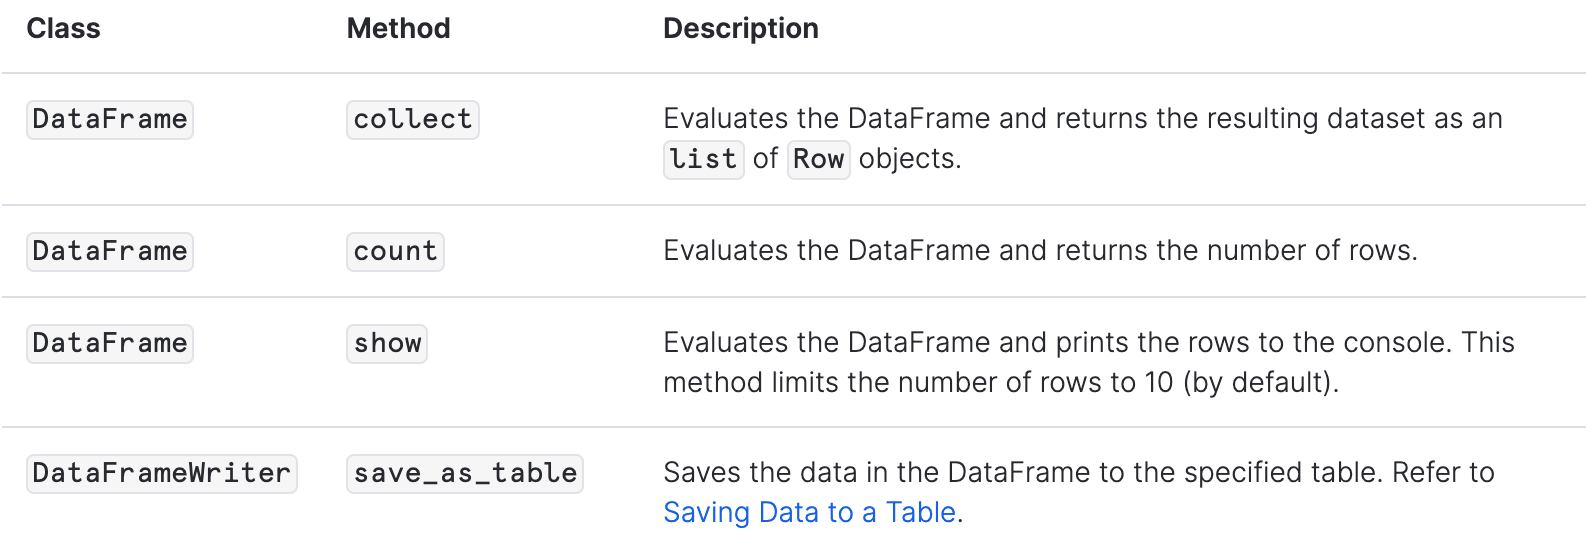

For example, to execute a query against a table and return the results, call the collect method:

In [2]:
# Create a DataFrame with the "id" and "name" columns from the "sample_product_data" table.
# This does not execute the query.
df = session.table("sample_product_data").select(col("id"), col("name"))

# Send the query to the server for execution and
# return a list of Rows containing the results.
results = df.collect()
results

[Row(ID=1, NAME='Product 1'),
 Row(ID=2, NAME='Product 1A'),
 Row(ID=3, NAME='Product 1B'),
 Row(ID=4, NAME='Product 2'),
 Row(ID=5, NAME='Product 2A'),
 Row(ID=6, NAME='Product 2B'),
 Row(ID=7, NAME='Product 3'),
 Row(ID=8, NAME='Product 3A'),
 Row(ID=9, NAME='Product 3B'),
 Row(ID=10, NAME='Product 4'),
 Row(ID=11, NAME='Product 4A'),
 Row(ID=12, NAME='Product 4B')]

To execute the query and return the number of results, call the count method:

In [3]:
# Create a DataFrame for the "sample_product_data" table.
df_products = session.table("sample_product_data")

# Send the query to the server for execution and
# print the count of rows in the table.
print(df_products.count())

12


To execute a query and print the results to the console, call the show method:

In [4]:
# Create a DataFrame for the "sample_product_data" table.
df_products = session.table("sample_product_data")

# Send the query to the server for execution and
# print the results to the console.
# The query limits the number of rows to 10 by default.
df_products.show()

-------------------------------------------------------------------------------------
|"ID"  |"PARENT_ID"  |"CATEGORY_ID"  |"NAME"      |"SERIAL_NUMBER"  |"KEY"  |"3rd"  |
-------------------------------------------------------------------------------------
|1     |0            |5              |Product 1   |prod-1           |1      |10     |
|2     |1            |5              |Product 1A  |prod-1-A         |1      |20     |
|3     |1            |5              |Product 1B  |prod-1-B         |1      |30     |
|4     |0            |10             |Product 2   |prod-2           |2      |40     |
|5     |4            |10             |Product 2A  |prod-2-A         |2      |50     |
|6     |4            |10             |Product 2B  |prod-2-B         |2      |60     |
|7     |0            |20             |Product 3   |prod-3           |3      |70     |
|8     |7            |20             |Product 3A  |prod-3-A         |3      |80     |
|9     |7            |20             |Product 3B  |pro

To limit the number of rows to 20:

In [5]:
# Create a DataFrame for the "sample_product_data" table.
df_products = session.table("sample_product_data")

# Send the query to the server for execution and
# print the results to the console.
# Limit the number of rows to 20, rather than 10
df_products.show(20)

-------------------------------------------------------------------------------------
|"ID"  |"PARENT_ID"  |"CATEGORY_ID"  |"NAME"      |"SERIAL_NUMBER"  |"KEY"  |"3rd"  |
-------------------------------------------------------------------------------------
|1     |0            |5              |Product 1   |prod-1           |1      |10     |
|2     |1            |5              |Product 1A  |prod-1-A         |1      |20     |
|3     |1            |5              |Product 1B  |prod-1-B         |1      |30     |
|4     |0            |10             |Product 2   |prod-2           |2      |40     |
|5     |4            |10             |Product 2A  |prod-2-A         |2      |50     |
|6     |4            |10             |Product 2B  |prod-2-B         |2      |60     |
|7     |0            |20             |Product 3   |prod-3           |3      |70     |
|8     |7            |20             |Product 3A  |prod-3-A         |3      |80     |
|9     |7            |20             |Product 3B  |pro

### `Return the Contents of a DataFrame as a Pandas DataFrame`

`to_pandas method`: return the contents of a DataFrame as a Pandas DataFrame

In [6]:
# Create a DataFrame for the "sample_product_data" table.
df_products = session.table("sample_product_data")
df_products.to_pandas()
#df_products.limit(10).to_pandas()

,ID,PARENT_ID,CATEGORY_ID,NAME,SERIAL_NUMBER,KEY,3rd
0,1,0,5,Product 1,prod-1,1,10
1,2,1,5,Product 1A,prod-1-A,1,20
2,3,1,5,Product 1B,prod-1-B,1,30
3,4,0,10,Product 2,prod-2,2,40
4,5,4,10,Product 2A,prod-2-A,2,50
5,6,4,10,Product 2B,prod-2-B,2,60
6,7,0,20,Product 3,prod-3,3,70
7,8,7,20,Product 3A,prod-3-A,3,80
8,9,7,20,Product 3B,prod-3-B,3,90
9,10,0,50,Product 4,prod-4,4,100


### `Saving Data to a Table`

- https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/latest/api/snowflake.snowpark.DataFrameWriter
- https://docs.snowflake.com/developer-guide/snowpark/reference/python/latest/api/snowflake.snowpark.DataFrameWriter.mode#snowflake.snowpark.DataFrameWriter.mode
- https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/latest/api/snowflake.snowpark.DataFrameWriter.save_as_table

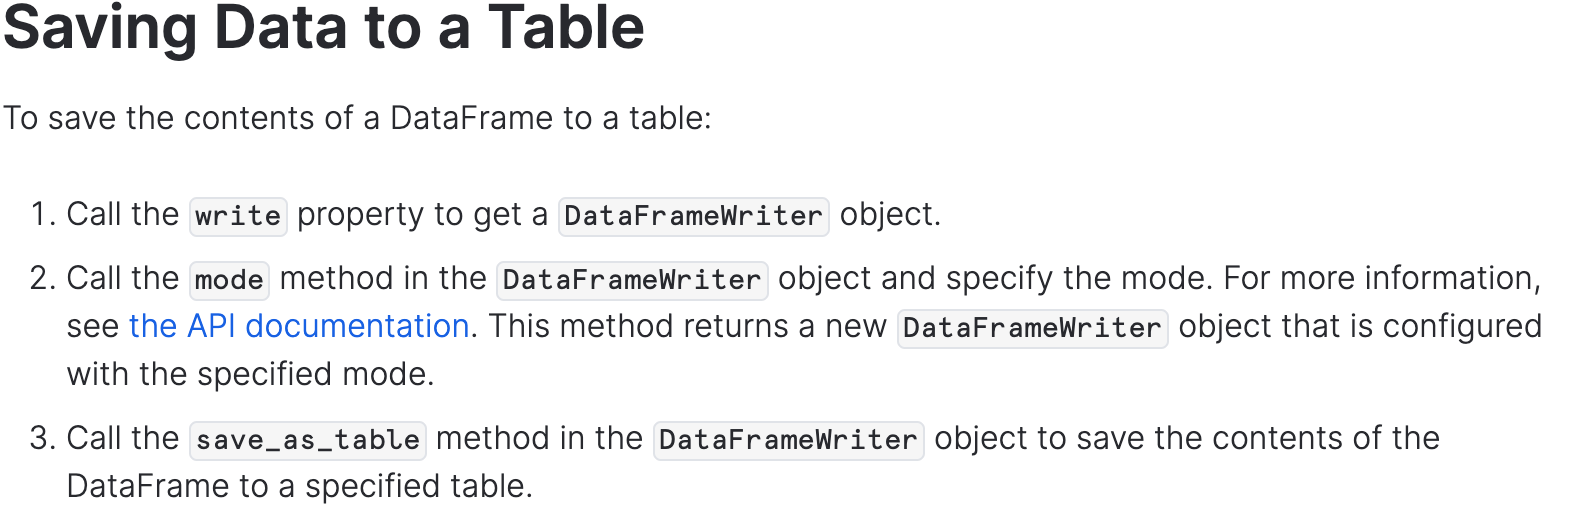

`Note` - that you do not need to call a separate method (e.g. `collect`) to execute the SQL statement that saves the data to the table.

In [7]:
# Create a DataFrame for the "sample_product_data" table.
df = session.table("sample_product_data")

In [10]:
# Write DataFrame result into Snowflake Table
df.write.mode("overwrite").save_as_table("sample_product_data1")

In [11]:
# Validate tables in snowpark_db database.
session.sql("show tables in schema snowpark_db.public").show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"created_on"                      |"name"                |"database_name"  |"schema_name"  |"kind"  |"comment"  |"cluster_by"  |"rows"  |"bytes"  |"owner"   |"retention_time"  |"automatic_clustering"  |"change_tracking"  |"search_optimization"  |"search_optimization_progress"  |"search_optimization_bytes"  |"is_external"  |"enable_schema_evolution"  |"owner_role_type"  |"is_event"  |"budget"  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### `Creating a View From a DataFrame`

Views that you create by calling `create_or_replace_view` are persistent. If you no longer need that view, you can `drop` the view `manually`.

Alternatively, use the `create_or_replace_temp_view` method, which creates a temporary view. The temporary view is only `available` in the `session` in which it is created.

`create_or_replace_view method`: To create a view from a DataFrame which immediately creates the new view

In [ ]:
# Option: 1
import os

database =  os.environ["snowflake_database"]
schema = os.environ["snowflake_schema"]
view_name = "my_view"

df.create_or_replace_view(f"{database}.{schema}.{view_name}")

In [13]:
database = "snowpark_db"
schema = "public"
view_name = "my_view"

df.create_or_replace_view(f"{database}.{schema}.{view_name}")

[Row(status='View MY_VIEW successfully created.')]

In [14]:
# Validate views in snowpark_db database.
session.sql("show views in schema snowpark_db.public").show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"created_on"                      |"name"   |"reserved"  |"database_name"  |"schema_name"  |"owner"   |"comment"  |"text"                                              |"is_secure"  |"is_materialized"  |"owner_role_type"  |"change_tracking"  |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|2023-12-08 08:21:19.658000-08:00  |MY_VIEW  |            |SNOWPARK_DB      |PUBLIC         |SYSADMIN  |           |CREATE  OR  REPLACE  VIEW snowpark_db.public.my...  |false        |false              |ROLE               |OFF                |
------------------------

### `Working With Files in a Stage`

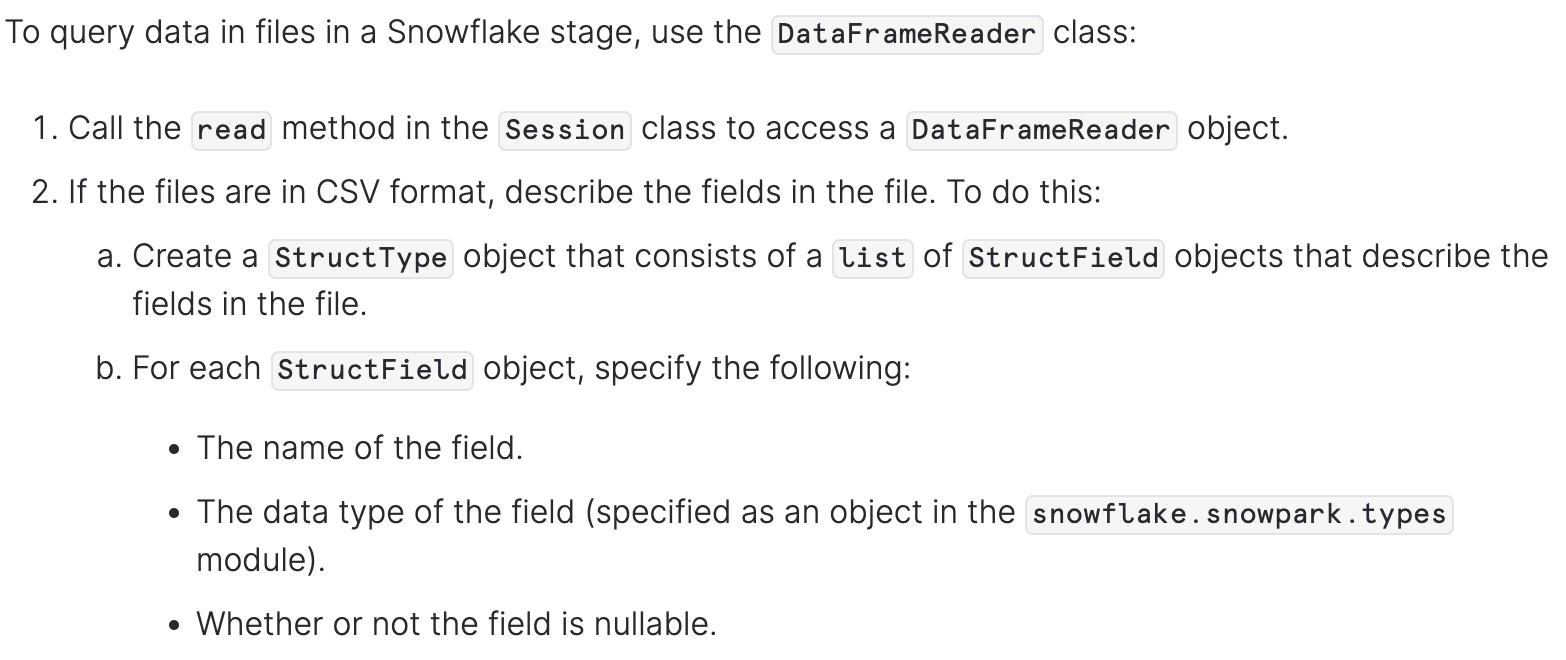

In [19]:
from snowflake.snowpark.types import StructType, StructField, StringType, IntegerType, DecimalType, LongType

schema_for_data_file =  StructType([
     StructField("Name", StringType())
    ,StructField("Age", IntegerType())
])

# Call the schema property in the DataFrameReader object, passing in the StructType object.
df_reader = session.read.schema(schema_for_data_file)

In [21]:
# option
df_catalog = (session.read.option("field_delimiter",",")
                          .option("skip_header", 1)
                          .schema(schema_for_data_file)
                          .csv("@sf_int_stg/data1.csv"))
df_catalog.show()

------------------
|"NAME"  |"AGE"  |
------------------
|AT&T    |100    |
|IBM     |100    |
------------------



In [20]:
# options
df_catalog = (session.read.options({"field_delimiter": ",", "skip_header": 1})
                          .schema(schema_for_data_file)
                          .csv("@sf_int_stg/data1.csv"))
df_catalog.show()

------------------
|"NAME"  |"AGE"  |
------------------
|AT&T    |100    |
|IBM     |100    |
------------------



In [23]:
# df_reader defined above
df_catalog =  df_reader.options({"field_delimiter": ",", "skip_header": 1}).csv("@sf_int_stg/data1.csv")
df_catalog.show()

------------------
|"NAME"  |"AGE"  |
------------------
|AT&T    |100    |
|IBM     |100    |
------------------



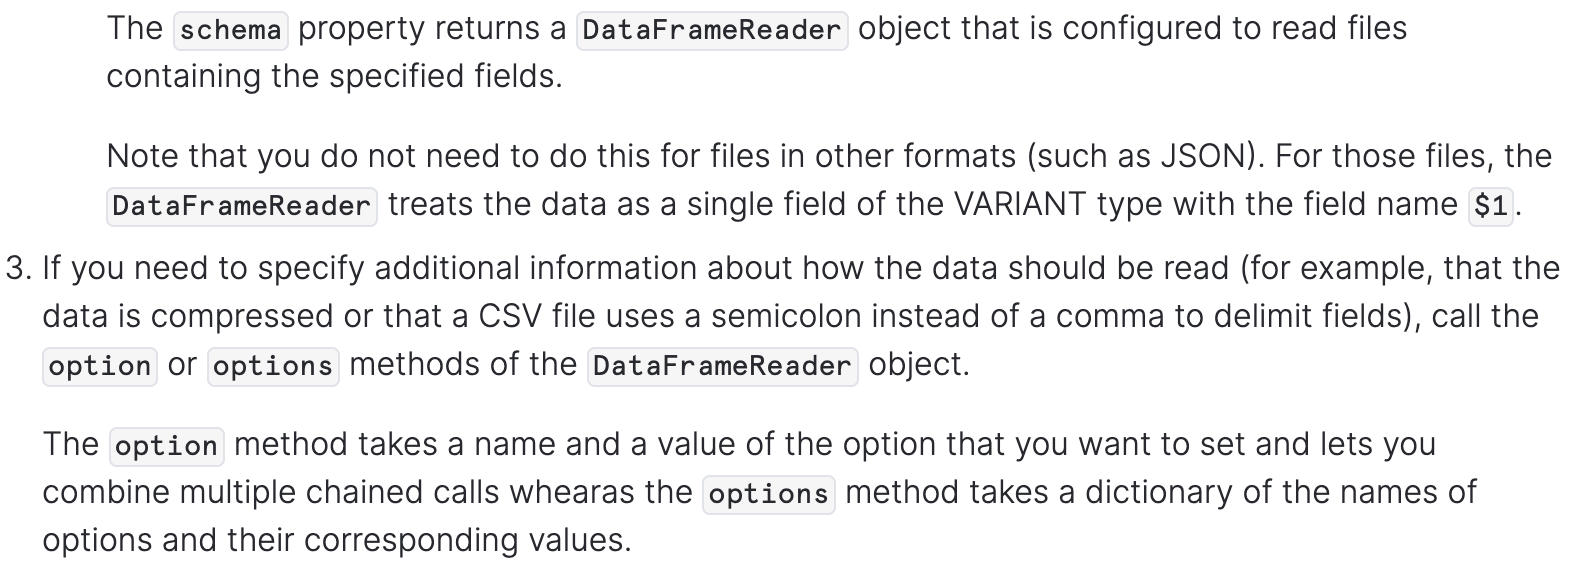

In [ ]:
# For example, to extract the sale_date element from a JSON file in the stage named SF_INT_STG:

In [25]:
session.sql("show stages in schema snowpark_db.public").show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"created_on"                      |"name"      |"database_name"  |"schema_name"  |"url"  |"has_credentials"  |"has_encryption_key"  |"owner"   |"comment"  |"region"  |"type"    |"cloud"  |"notification_channel"  |"storage_integration"  |"endpoint"  |"owner_role_type"  |"directory_enabled"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|2023-12-08 07:28:19.927000-08:00  |SF_INT_STG  |SNOWPARK_DB      |PUBLIC         |       |N                  |N      

In [26]:
session.sql("list @SF_INT_STG/").show()

----------------------------------------------------------------------------------------------------
|"name"                 |"size"  |"md5"                             |"last_modified"               |
----------------------------------------------------------------------------------------------------
|sf_int_stg/data1.csv   |32      |ba2e510d1d6a424a5b0da2be426dad7f  |Fri, 8 Dec 2023 15:30:23 GMT  |
|sf_int_stg/data1.json  |80      |1a1c422f98f927bb42fdcdecab72faae  |Fri, 8 Dec 2023 15:30:23 GMT  |
|sf_int_stg/sales.json  |320     |6019c0d9cef2959d7e6cd54ce6319904  |Fri, 8 Dec 2023 15:30:23 GMT  |
----------------------------------------------------------------------------------------------------



In [30]:
# Import the sql_expr function from the functions module
from snowflake.snowpark.functions import sql_expr

df = session.read.json('@SF_INT_STG/sales.json').select(sql_expr("$1:sale_date::date").alias("sale_date"))
df.show()


---------------
|"SALE_DATE"  |
---------------
|2017-03-05   |
|2017-03-17   |
|2017-03-21   |
---------------



This example uses the `sql_expr` function in the `snowflake.snowpark.functions` module to specify the path to the color element.

- https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/latest/api/snowflake.snowpark.functions.sql_expr

In [35]:
# Import the sql_expr function from the functions module
from snowflake.snowpark.functions import sql_expr

df = (session.read.json('@SF_INT_STG/sales.json')
                  .select(sql_expr("$1:location").alias("location")
                         ,sql_expr("$1:location.state_city::string").alias("state_city") 
                         ,sql_expr("$1:location.zip::int").alias("state_city") 
                         ,sql_expr("$1:sale_date::date").alias("sale_date")
                         ,sql_expr("$1:price::integer").alias("price")
                          )
    )
df.show()

-------------------------------------------------------------------------------------------
|"LOCATION"                        |"STATE_CITY"   |"STATE_CITY"  |"SALE_DATE"  |"PRICE"  |
-------------------------------------------------------------------------------------------
|{                                 |MA-Lexington   |40503         |2017-03-05   |275836   |
|  "state_city": "MA-Lexington",   |               |              |             |         |
|  "zip": "40503"                  |               |              |             |         |
|}                                 |               |              |             |         |
|{                                 |MA-Belmont     |2478          |2017-03-17   |392567   |
|  "state_city": "MA-Belmont",     |               |              |             |         |
|  "zip": "02478"                  |               |              |             |         |
|}                                 |               |              |             

### `Working with Semi-Structured Data`

- https://docs.snowflake.com/en/user-guide/querying-semistructured#label-sample-data-semistructured-data

In [37]:
session.sql("""CREATE OR REPLACE TABLE car_sales
( 
  src variant
)
AS
SELECT PARSE_JSON(column1) AS src
FROM VALUES
('{ 
    "date" : "2017-04-28", 
    "dealership" : "Valley View Auto Sales",
    "salesperson" : {
      "id": "55",
      "name": "Frank Beasley"
    },
    "customer" : [
      {"name": "Joyce Ridgely", "phone": "16504378889", "address": "San Francisco, CA"}
    ],
    "vehicle" : [
      {"make": "Honda", "model": "Civic", "year": "2017", "price": "20275", "extras":["ext warranty", "paint protection"]}
    ]
}'),
('{ 
    "date" : "2017-04-28", 
    "dealership" : "Tindel Toyota",
    "salesperson" : {
      "id": "274",
      "name": "Greg Northrup"
    },
    "customer" : [
      {"name": "Bradley Greenbloom", "phone": "12127593751", "address": "New York, NY"}
    ],
    "vehicle" : [
      {"make": "Toyota", "model": "Camry", "year": "2017", "price": "23500", "extras":["ext warranty", "rust proofing", "fabric protection"]}  
    ]
}') v
""").collect()

[Row(status='Table CAR_SALES successfully created.')]

In [41]:
# For example, the following code selects the dealership field in objects in the src column of the sample data:
df = session.table("CAR_SALES")

df.select(col("src")["dealership"].as_("dealership")).show()

----------------------------
|"DEALERSHIP"              |
----------------------------
|"Valley View Auto Sales"  |
|"Tindel Toyota"           |
----------------------------



In [42]:
# You can also chain method calls to traverse a path to a specific field or element.
# For example, the following code selects the name field in the salesperson object:
df.select(df["src"]["salesperson"]["name"].alias("salesperson_name")).show()

----------------------
|"SALESPERSON_NAME"  |
----------------------
|"Frank Beasley"     |
|"Greg Northrup"     |
----------------------



In [44]:
# As another example, the following code selects the first element of vehicle field, which holds an array of vehicles. The example also selects the price field from the first element.
df.select(df["src"]["vehicle"][0]).show()

df.select(df["src"]["vehicle"][0]["price"]).show()

---------------------------
|"""SRC""['VEHICLE'][0]"  |
---------------------------
|{                        |
|  "extras": [            |
|    "ext warranty",      |
|    "paint protection"   |
|  ],                     |
|  "make": "Honda",       |
|  "model": "Civic",      |
|  "price": "20275",      |
|  "year": "2017"         |
|}                        |
|{                        |
|  "extras": [            |
|    "ext warranty",      |
|    "rust proofing",     |
|    "fabric protection"  |
|  ],                     |
|  "make": "Toyota",      |
|  "model": "Camry",      |
|  "price": "23500",      |
|  "year": "2017"         |
|}                        |
---------------------------

------------------------------------
|"""SRC""['VEHICLE'][0]['PRICE']"  |
------------------------------------
|"20275"                           |
|"23500"                           |
------------------------------------



In [48]:
# As an alternative to access fields in aforementioned way, you can use get, get_ignore_case, or get_path functions if the field name or elements in the path are irregular.
from snowflake.snowpark.functions import get, get_path, lit

# Both method resturns same
df.select(get(col("src"),lit("dealership"))).show()
df.select(col("src")["dealership"]).show()

--------------------------------
|"GET(""SRC"", 'DEALERSHIP')"  |
--------------------------------
|"Valley View Auto Sales"      |
|"Tindel Toyota"               |
--------------------------------

----------------------------
|"""SRC""['DEALERSHIP']"   |
----------------------------
|"Valley View Auto Sales"  |
|"Tindel Toyota"           |
----------------------------



In [50]:
# Similarly, the following lines of code both print the value of a field at a specified path in an object:
df.select(get_path(col("src"), lit("vehicle[0].make"))).show()
df.select(col("src")["vehicle"][0]["make"]).show()

------------------------------------------
|"GET_PATH(""SRC"", 'VEHICLE[0].MAKE')"  |
------------------------------------------
|"Honda"                                 |
|"Toyota"                                |
------------------------------------------

-----------------------------------
|"""SRC""['VEHICLE'][0]['MAKE']"  |
-----------------------------------
|"Honda"                          |
|"Toyota"                         |
-----------------------------------



`Explicitly Casting Values in Semi-Structured Data`

In [57]:
# To avoid unexpected results, call the cast method to cast the value to a specific type. For example, the following code prints out the values without and with casting:
df = session.table("car_sales")
df.select(col("src")["salesperson"]["id"]).show()

df.select(col("src")["salesperson"]["id"].cast(IntegerType())).show()

----------------------------------
|"""SRC""['SALESPERSON']['ID']"  |
----------------------------------
|"55"                            |
|"274"                           |
----------------------------------

------------------------------------------------
|"CAST (""SRC""['SALESPERSON']['ID'] AS INT)"  |
------------------------------------------------
|55                                            |
|274                                           |
------------------------------------------------



### `Flattening an Array of Objects into Rows`

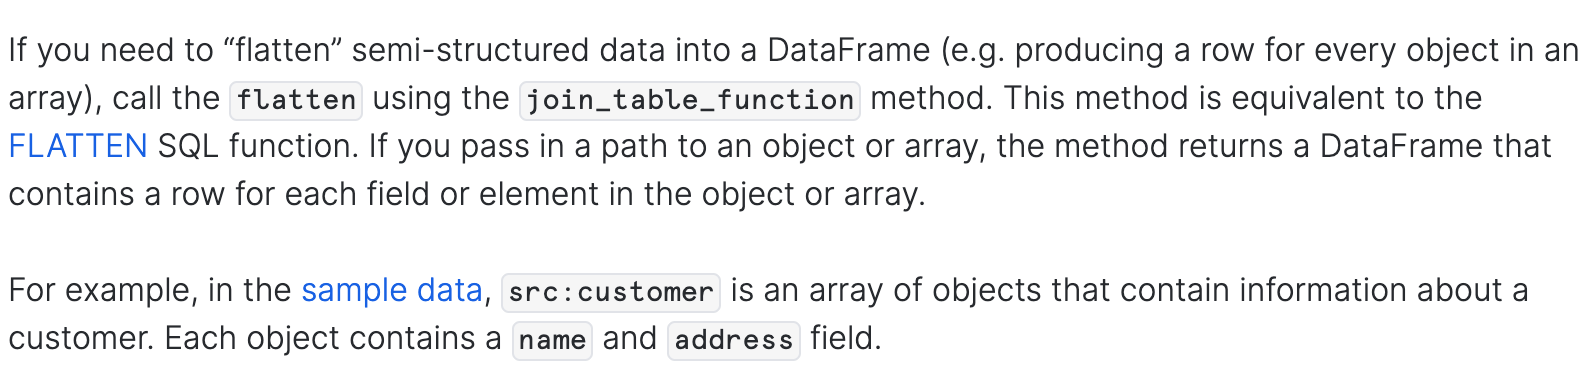

- https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/latest/api/snowflake.snowpark.DataFrame.flatten

In [58]:
df = session.table("car_sales")
df.show()

---------------------------------------------
|"SRC"                                      |
---------------------------------------------
|{                                          |
|  "customer": [                            |
|    {                                      |
|      "address": "San Francisco, CA",      |
|      "name": "Joyce Ridgely",             |
|      "phone": "16504378889"               |
|    }                                      |
|  ],                                       |
|  "date": "2017-04-28",                    |
|  "dealership": "Valley View Auto Sales",  |
|  "salesperson": {                         |
|    "id": "55",                            |
|    "name": "Frank Beasley"                |
|  },                                       |
|  "vehicle": [                             |
|    {                                      |
|      "extras": [                          |
|        "ext warranty",                    |
|        "paint protection"       

In [59]:
# call the flatten using the join_table_function method
df.join_table_function("flatten", col("src")["customer"]).show()

----------------------------------------------------------------------------------------------------------------------------------------------------------
|"SRC"                                      |"SEQ"  |"KEY"  |"PATH"  |"INDEX"  |"VALUE"                            |"THIS"                               |
----------------------------------------------------------------------------------------------------------------------------------------------------------
|{                                          |1      |NULL   |[0]     |0        |{                                  |[                                    |
|  "customer": [                            |       |       |        |         |  "address": "San Francisco, CA",  |  {                                  |
|    {                                      |       |       |        |         |  "name": "Joyce Ridgely",         |    "address": "San Francisco, CA",  |
|      "address": "San Francisco, CA",      |       |       |        |

In [64]:
# From this DataFrame, you can select the name and address fields from each object in the VALUE field:
#df.join_table_function("flatten", col("src")["customer"]).select(col("value")["name"], col("value")["address"]).show()
(df.join_table_function("flatten", col("src")["customer"])
   .select(col("value")["name"].cast(StringType()).alias("name")
          ,col("value")["address"].cast(StringType()).alias("address"))
   .show()
)

------------------------------------------
|"NAME"              |"ADDRESS"          |
------------------------------------------
|Joyce Ridgely       |San Francisco, CA  |
|Bradley Greenbloom  |New York, NY       |
------------------------------------------



In [66]:
# From this DataFrame, you can select the name and address fields from each object in the VALUE field:
#df.join_table_function("flatten", col("src")["customer"]).select(col("value")["name"], col("value")["address"]).show()
(df.join_table_function("flatten", col("src")["customer"])
   .select(sql_expr("VALUE:name::string").alias("name")
          ,sql_expr("VALUE:address::string").alias("address"))
   .show()
)

------------------------------------------
|"NAME"              |"ADDRESS"          |
------------------------------------------
|Joyce Ridgely       |San Francisco, CA  |
|Bradley Greenbloom  |New York, NY       |
------------------------------------------



In [67]:
# The following code adds to the previous example by casting the values to a specific type and changing the names of the columns:
df.join_table_function("flatten", col("src")["customer"]).select(col("value")["name"].cast(StringType()).as_("Customer Name"), col("value")["address"].cast(StringType()).as_("Customer Address")).show()

-------------------------------------------
|"Customer Name"     |"Customer Address"  |
-------------------------------------------
|Joyce Ridgely       |San Francisco, CA   |
|Bradley Greenbloom  |New York, NY        |
-------------------------------------------



### `Executing SQL Statements`

In [90]:
# call the sql method in the Session class, and pass in the statement to be executed. The method returns a DataFrame.
# Note: that the SQL statement won’t be executed until you call an action method.

# Get list of files in the stage
stage_files_df = session.sql("list @SF_INT_STG").collect()
stage_files_df

[Row(name='sf_int_stg/car_sales.json', size=848, md5='d69652cd0d10f4651db31c180bd8dff6', last_modified='Fri, 8 Dec 2023 17:25:35 GMT'),
 Row(name='sf_int_stg/car_sales1.json', size=656, md5='04c4262b096991965a9887a75393ef8d', last_modified='Sat, 9 Dec 2023 00:59:33 GMT'),
 Row(name='sf_int_stg/data1.csv', size=32, md5='ba2e510d1d6a424a5b0da2be426dad7f', last_modified='Fri, 8 Dec 2023 15:30:23 GMT'),
 Row(name='sf_int_stg/data1.json', size=80, md5='1a1c422f98f927bb42fdcdecab72faae', last_modified='Fri, 8 Dec 2023 15:30:23 GMT'),
 Row(name='sf_int_stg/sales.json', size=320, md5='6019c0d9cef2959d7e6cd54ce6319904', last_modified='Fri, 8 Dec 2023 15:30:23 GMT')]

In [88]:
session.sql("rm @sf_int_stg/car_sales1").collect()

[Row(name='sf_int_stg/car_sales1', result='removed')]

In [89]:
# Unload data as JSON to internal stage
session.sql("copy into @SF_INT_STG/car_sales1.json from car_sales file_format = (type=JSON, COMPRESSION = NONE) SINGLE = TRUE OVERWRITE = TRUE").collect()

[Row(rows_unloaded=2, input_bytes=648, output_bytes=648)]

In [91]:
session.read.json("@SF_INT_STG/car_sales1.json").show()

---------------------------------------------
|"$1"                                       |
---------------------------------------------
|{                                          |
|  "customer": [                            |
|    {                                      |
|      "address": "San Francisco, CA",      |
|      "name": "Joyce Ridgely",             |
|      "phone": "16504378889"               |
|    }                                      |
|  ],                                       |
|  "date": "2017-04-28",                    |
|  "dealership": "Valley View Auto Sales",  |
|  "salesperson": {                         |
|    "id": "55",                            |
|    "name": "Frank Beasley"                |
|  },                                       |
|  "vehicle": [                             |
|    {                                      |
|      "extras": [                          |
|        "ext warranty",                    |
|        "paint protection"       

In [92]:
session.sql("create or replace table sales_test (src variant)").collect()

[Row(status='Table SALES_TEST successfully created.')]

In [93]:
# Set up a SQL statement to copy data from a stage to a table.
session.sql("copy into sales_test from @SF_INT_STG/car_sales1.json file_format = (type=JSON )").collect()

[Row(file='sf_int_stg/car_sales1.json', status='LOADED', rows_parsed=2, rows_loaded=2, error_limit=1, errors_seen=0, first_error=None, first_error_line=None, first_error_character=None, first_error_column_name=None)]

In [94]:
df = session.table("sales_test")
df.show()

---------------------------------------------
|"SRC"                                      |
---------------------------------------------
|{                                          |
|  "customer": [                            |
|    {                                      |
|      "address": "San Francisco, CA",      |
|      "name": "Joyce Ridgely",             |
|      "phone": "16504378889"               |
|    }                                      |
|  ],                                       |
|  "date": "2017-04-28",                    |
|  "dealership": "Valley View Auto Sales",  |
|  "salesperson": {                         |
|    "id": "55",                            |
|    "name": "Frank Beasley"                |
|  },                                       |
|  "vehicle": [                             |
|    {                                      |
|      "extras": [                          |
|        "ext warranty",                    |
|        "paint protection"       

If you want to call methods to transform the DataFrame `(e.g. filter, select, etc.)`, note that these methods work only if the underlying SQL statement is a `SELECT` statement. The transformation methods are not supported for `other kinds` of SQL statements.

In [97]:
df = session.sql("select id, parent_id from sample_product_data where id < 10")

# Because the underlying SQL statement for the DataFrame is SELECT statement
# you can call the filter method to transform this DataFrame
results = df.filter(col("id") < 3).select(col("id"))
results.show()


--------
|"ID"  |
--------
|1     |
|2     |
--------



In [103]:
# In this example, the underlying SQL statement is not a SELECT statement
df = session.sql("ls @SF_INT_STG")
df.show()

---------------------------------------------------------------------------------------------------------
|"name"                      |"size"  |"md5"                             |"last_modified"               |
---------------------------------------------------------------------------------------------------------
|sf_int_stg/car_sales.json   |848     |d69652cd0d10f4651db31c180bd8dff6  |Fri, 8 Dec 2023 17:25:35 GMT  |
|sf_int_stg/car_sales1.json  |656     |04c4262b096991965a9887a75393ef8d  |Sat, 9 Dec 2023 00:59:33 GMT  |
|sf_int_stg/data1.csv        |32      |ba2e510d1d6a424a5b0da2be426dad7f  |Fri, 8 Dec 2023 15:30:23 GMT  |
|sf_int_stg/data1.json       |80      |1a1c422f98f927bb42fdcdecab72faae  |Fri, 8 Dec 2023 15:30:23 GMT  |
|sf_int_stg/sales.json       |320     |6019c0d9cef2959d7e6cd54ce6319904  |Fri, 8 Dec 2023 15:30:23 GMT  |
---------------------------------------------------------------------------------------------------------



In [100]:
# In this example, the underlying SQL statement is not a SELECT statement
df = session.sql("ls @SF_INT_STG")

# calling the filter method results in an error
try:
    df.filter(col("size") > 50).collect()
except SnowparkSQLException as e:
    print(e.message)

000904 (42000): SQL compilation error: error line 1 at position 104
invalid identifier 'SIZE'


In [86]:
# Closing a Session
session.close()